<a href="https://colab.research.google.com/github/dnguyen25/Stock-Prediction/blob/main/Stock-Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Coding exercises

Below, we will use a state space model to make predictions of stock prices from a historical stock market dataset.

For linear dynamical systems modeling, we'll use the SSM package from here:
https://github.com/lindermanlab/ssm

The following code works for me in a Google Colab notebook run in the cloud, but you may need to do things differently to run on your local machine.

In [ ]:
# Install the SSM package:
!pip install ssm

# Because of an unfortunate compatability issue, we need to downgrade our version
# of SciPy in order to run the SSM package:
!pip3 install scipy==1.2.1
import scipy
print(scipy.__version__)

     |████████████████████████████████| 309 kB 2.7 MB/s 
  Created wheel for ssm: filename=ssm-0.0.1-cp37-cp37m-linux_x86_64.whl size=679506 sha256=0375a11289b23a2e2539842b6c96becf48e3d2e9edcc80dfbfd5f46ac45f80aa
  Stored in directory: /root/.cache/pip/wheels/9a/5d/5e/c0df5ced25437a4d71782c101f07b53d6a5fb1ad81b59b26b0
Successfully built ssm
     |████████████████████████████████| 24.8 MB 1.5 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
1.2.1


To test that everything is working, here is a simple example in which a hidden Markov model with random parameters is created, sampled from, and fit using the SSM package:

In [ ]:
import ssm
T = 100  # number of time bins
K = 5    # number of discrete states
D = 2    # dimension of the observations

# Create an HMM as a generative model and sample from it:
hmm = ssm.HMM(K, D, observations="gaussian")
z, y = hmm.sample(T)
print('True hidden states: ', z)

# Fit the hmm and print the inferred hidden states
# (remember that the labels might not correspond to those for the true model):
test_hmm = ssm.HMM(K, D, observations="gaussian")
test_hmm.fit(y)
zhat = test_hmm.most_likely_states(y)
print('Inferred hidden states: ', zhat)


True hidden states:  [4 4 4 4 4 4 4 4 4 4 4 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0
 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


  0%|          | 0/100 [00:00<?, ?it/s]

Inferred hidden states:  [4 4 4 4 4 4 4 4 4 4 4 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3
 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


## Stock price prediction

In what follows, we'll use an LDS state space model to try to predict stock prices over time. We'll use historical data downloaded from here:

https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs

The data has been preprocessed a bit to get it into a nice format. It is in the form of a 2D Numpy array, where each row corresponds to a day on which the stock market was open during the years 2000-2017, and each column corresponds to a publicly traded company. (If you are curious, the file company_list.txt provides the abbreviated names of the companies that are included in the dataset.) Each entry in the array gives the opening stock price for a particular company on a particular day.

**Disclaimer**: Before you go and invest all of your savings in the market based on this exercise, please consider the following:
1. This version of the dataset is biased because it includes only companies that existed throughout the period 2000-2017. It excludes companies that appeared or disappeared at any point during that time.
2. In cases where stock prices were missing for some days for some companies, the price from that company from the nearest adjacent day was used to fill in the missing data.

In [ ]:
# Upload the preprocessed data (prices.npy) from local computer to the cloud:
from google.colab import files
files.upload();

Saving prices.npy to prices.npy


In [ ]:
# Load the data:
prices = np.load('prices.npy')
n_days, n_companies = np.shape(prices)
print('n_days, n_companies: ', n_days, n_companies)

n_days, n_companies:  6521 106


Text(0, 0.5, 'Price ($)')

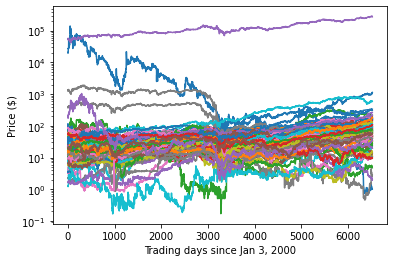

In [ ]:
# Look at the data:

plt.semilogy(prices[:,:])
plt.xlabel('Trading days since Jan 3, 2000')
plt.ylabel('Price ($)')

Average return:  5.4499346225389855


Text(0, 0.5, 'Normalized price')

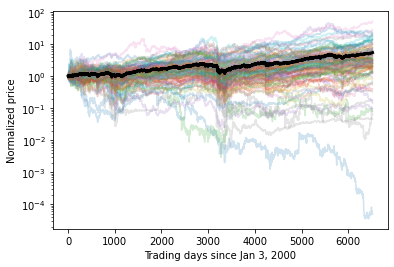

In [ ]:
# Normalize each line by its value on the first day:
starting_prices = prices[0,:]
prices_norm = prices / starting_prices

# The average normalized stock price (with all companies weighted equally):
market_average = np.mean(prices_norm, axis=1)

# The return per dollar invested if investing equally in all companies:
avg_return = market_average[-1]/market_average[0]
print('Average return: ', avg_return)

# Plot the normalized data:
plt.semilogy(prices_norm, alpha=0.2)
plt.semilogy(market_average, c='k', lw=3)
plt.xlabel('Trading days since Jan 3, 2000')
plt.ylabel('Normalized price')

The LDS model is described by the following equations:
$$
p(\mathbf{z}_n | \mathbf{z}_{n-1})
= \mathcal{N}(\mathbf{z}_n | \mathbf{Az}_{n-1}, \mathbf{\Gamma}) \\
p(\mathbf{x}_n | \mathbf{z}_n)
= \mathcal{N} (\mathbf{x}_n | \mathbf{Cz}_n + \mathbf{d}, \mathbf{\Sigma}),
$$
where the covariance matrix $\mathbf{\Sigma}$ is assumed to be diagonal, so it appears as a vector (i.e. just the diagonal elements) rather than as a matrix below. Note also the presence of a bias vector $\mathbf{d}$ in the emission model, which is not present in the textbook example that we discussed in class.

In the following block of code, we'll fit an LDS model to the stock data and plot the inferred latent states.

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0, 0.5, 'Latent state')

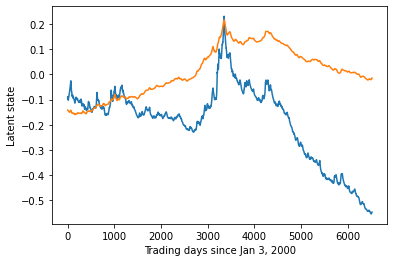

In [ ]:
# Set the parameters of the LDS:
time_bins = n_days   # number of time bins
state_dim = 2     # number of latent dimensions
obs_dim = n_companies      # number of observed dimensions

# Because prices vary over many orders of magnitude, we'll use the log:
data = np.log(prices_norm)

# Fit the model using the full dataset:
lds = ssm.LDS(obs_dim, state_dim, emissions="gaussian")
elbos, q = lds.fit(data, method="laplace_em", num_iters=10)

# The model's inferred latent states:
state_means = q.mean_continuous_states[0]

# Plot the inferred latent states:
plt.plot(state_means)
plt.xlabel('Trading days since Jan 3, 2000')
plt.ylabel('Latent state')



In [ ]:
# Get the model parameters:
A = lds.dynamics.As[0]
Gamma = lds.dynamics.Sigmas[0]
C = lds.emissions.Cs[0]
d = lds.emissions.ds[0]
Sig = lds.emissions.params[-1][0]

for x in [A, Gamma, C, d, Sig]:
    print(x.shape)

(2, 2)
(2, 2)
(106, 2)
(106,)
(106,)


**Goal** Use LDS modeling to see whether you can beat the market. To do this, we choose a day $d$ in the middle of the dataset and train a model using data from the preceding days. Using the parameters from the model, we predict the evolution of the latent states and the most likely observations under the model over, the following $\tau = 15$ or so trading days. Using this information we determine how you should invest a dollar on day $d$ among different companies to earn a high expected return on day $d+\tau$. Then we use the data to calculate the actual return that your strategy would yield over this interval, and compare this with what you would have earned by simply dividing your dollar equally among all of the companies. By repeating all of this for many different $d$, we quantify whether your model enables you, on average, to obtain better returns than the simpler investment strategy.


These next block I used primarily for testing various values for the dimension of the latent space and for the time interval.

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Text(0, 0.5, 'Latent state')

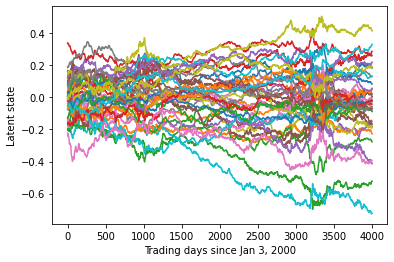

In [ ]:
# Set the parameters of the LDS:

time_bins = 4000   # number of time bins
state_dim = 40     # number of latent dimensions
obs_dim = n_companies      # number of observed dimensions

# Because prices vary over many orders of magnitude, we'll use the log:
data = np.log(prices_norm)

# Fit the model using the full dataset:
lds = ssm.LDS(obs_dim, state_dim, emissions="gaussian")
elbos, q = lds.fit(data[0:time_bins], method="laplace_em", num_iters=9)

# The model's inferred latent states:
state_means = q.mean_continuous_states[0]

# Plot the inferred latent states:
plt.plot(state_means)
plt.xlabel('Trading days since Jan 3, 2000')
plt.ylabel('Latent state')

In [ ]:
A = lds.dynamics.As[0]
Gamma = lds.dynamics.Sigmas[0]
C = lds.emissions.Cs[0]
d = lds.emissions.ds[0]
Sig = lds.emissions.params[-1][0]

for x in [A, Gamma, C, d, Sig]:
    print(x.shape)

(40, 40)
(40, 40)
(106, 40)
(106,)
(106,)


In [ ]:


def pred(init,time,z):
#init is the status of the market at the beginning of the investment
#z is the latent state of the market.
#This gives the gains relative to 2000.
  new_state= C@(A**(int(time))@z)+d
  new_value= np.array([ ((np.exp(new_state[i]))/np.exp(init[i]))**(1/time) for i in range(106)])
#returns the percentage gain per day.
  return new_value

#Chooses the strategy that we will use given a predicted set of gains.
def strategy(gains,risk):
#We obviously want to put more money into stocks we expect to rise than stocks we expect to fall.
#However, we don't want to concentrate too much money into a few stocks.
#I have chosen a power function of the gain because it allows me to choose the risk.
#A higher risk means more guessing and a lower risk means a more diversified portfolio.
#We can tune this hyperparameter.
  strat=gains**risk
  return strat/sum(strat)
def actual_gains(strat,start,end):
  new_value= np.array([strat[i]*(np.exp(data[end,i]-data[start,i])) for i in range(106)])
  return sum(new_value)/sum(strat)




In [ ]:
K=0
l=0
for i in range(12,3150,20):
  l+=1
  p=pred(data[i,:],30, state_means[i])
  K+=actual_gains(strategy(p,1000),i,i+20)-actual_gains(np.ones(106),i,i+30)
K/l

0.02780262451378958

The next two blocks of code represent my actual model. Note that it took my computer about 30 minutes to run this code. If you want it to be faster, increase the interval in the for loop.

In [ ]:
#The number of day in the future that we are trying to forecast and beat the market over.
time=15
Result=[]
runs=0
for initial_time in range(4001,6300,100):
  # Set the parameters of the LDS:

  time_bins = initial_time   # number of time bins
  state_dim = 40     # number of latent dimensions
  obs_dim = n_companies      # number of observed dimensions

  # Because prices vary over many orders of magnitude, we'll use the log:
  data = np.log(prices_norm)

  # Fit the model using the full dataset:
  lds = ssm.LDS(obs_dim, state_dim, emissions="gaussian")
  elbos, q = lds.fit(data[0:time_bins], method="laplace_em", num_iters=9)

  # The model's inferred latent states:
  state_means = q.mean_continuous_states[0]

  #The model's parameters
  A = lds.dynamics.As[0]
  Gamma = lds.dynamics.Sigmas[0]
  C = lds.emissions.Cs[0]
  d = lds.emissions.ds[0]
  Sig = lds.emissions.params[-1][0]

  #predicts the growth of the market
  predicted_state= C@(A**(int(time))@state_means[time])+d
  gains= np.array([ ((np.exp(predicted_state[i]))/np.exp(data[initial_time,i])) for i in range(106)])

  #We obviously want to put more money into stocks we expect to rise than stocks we expect to fall.
  #However, we don't want to concentrate too much money into a few stocks.
  #I have chosen a power function of the gain because it allows me to choose the risk.
  #A higher risk means more guessing and a lower risk means a more diversified portfolio.
  #I choose a large risk, which effectively emphasizes picks the very best stocks.

  strat=gains**2

  #Computes our performance and records it.
  Result.append(actual_gains(strat,initial_time,initial_time+time)-actual_gains(np.ones(106),initial_time,initial_time+time))
  runs+=1




Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
#This will output the average overperformance. It is not large but it is positive.


sum(Result)/runs

0.004138919433404859

I did manage to make the algorithm overperform the market but with a few caveats. The time interval can't be increased much over 20. It takes a long time to test the algorithm like we did up above, but once tested it only takes about 1 minute to make the next prediction. I chose a 40-dimensional latent variable to balance training time with accuracy. I suspect that in truth the market has many more latent variables (probably at least the number of companies). If I were really investing money, I probably would choose a higher dimensional latent variable to capture more information.